### Music gereration firth Keras and TensorFlow backend

Plan was simple:
1. Read midi file, convert it to matrix of features
2. Create simple model with Keras and LSTM to learn the pattern
3. Use subsample of initial midi file as a input for model to generate pure art
4. Save prediction from model to midi file
.
.
.
5. PROFIT

<i> For disclamer: I've been using my macbook with no GPU support</i>

In [1]:
import sys

!{sys.executable} -m pip install -q mido tqdm pandas tensorflow scikit-learn
# on my macOS I couldn't import keras properly, so I reinstall it with this command
# maybe you will need it too 🤷‍♂️
# !{sys.executable} -m  pip uninstall -y tensorflow keras tf-nightly keras-nightly

In [2]:
import mido
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
from mido import Message, MidiFile, MidiTrack
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence

2023-11-28 11:59:09.900546: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 11:59:09.932551: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 11:59:09.933509: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 11:59:10.583090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##### Read midi file

In [3]:
mid_path = 'Samples/Nintendo_-_Pokemon_Fire_Red_Route_1_Piano_Cover_Hard_Version.mid'
mid = MidiFile(mid_path)
notes = []

##### Visualization of the MIDI file


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


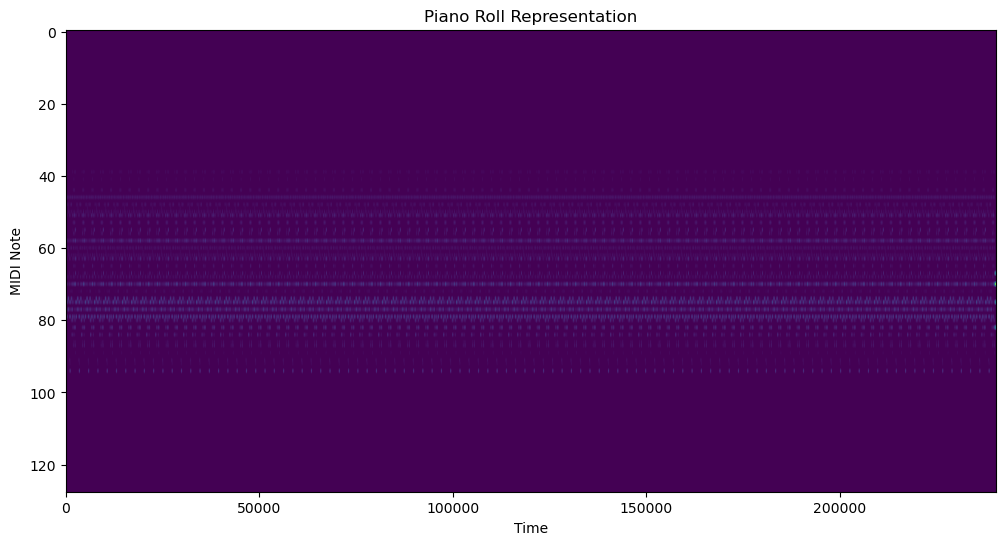

In [4]:
midi_file = pretty_midi.PrettyMIDI(mid_path)
piano_roll = midi_file.get_piano_roll()

plt.figure(figsize=(12, 6))
plt.imshow(piano_roll, aspect='auto', cmap='viridis')
plt.xlabel('Time')
plt.ylabel('MIDI Note')
plt.title('Piano Roll Representation')
plt.show()

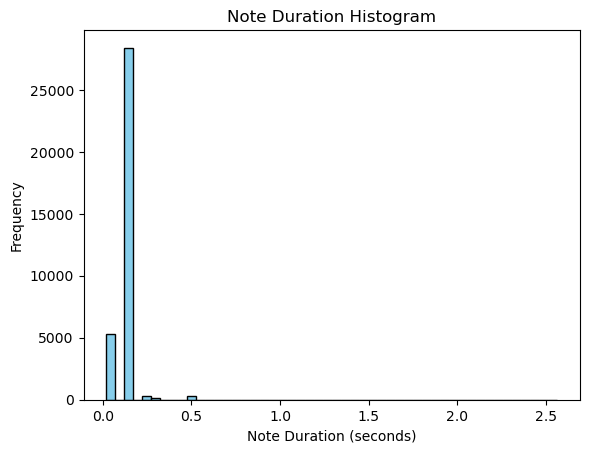

In [5]:
midi_file = pretty_midi.PrettyMIDI(mid_path)
note_durations = [note.end - note.start for instrument in midi_file.instruments for note in instrument.notes]

plt.hist(note_durations, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Note Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Note Duration Histogram')
plt.show()

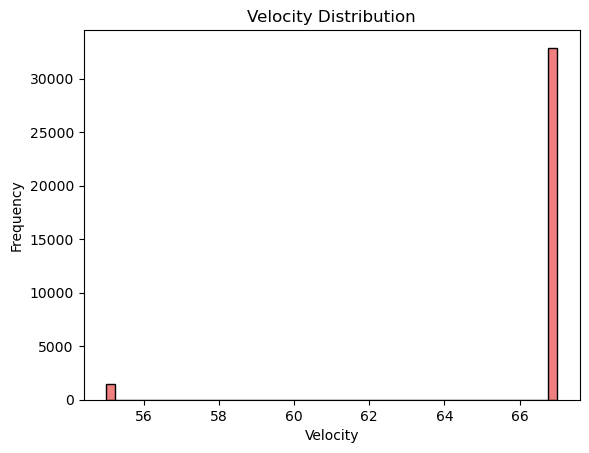

In [6]:
midi_file = pretty_midi.PrettyMIDI(mid_path)
velocities = [note.velocity for instrument in midi_file.instruments for note in instrument.notes]

plt.hist(velocities, bins=50, color='lightcoral', edgecolor='black')
plt.xlabel('Velocity')
plt.ylabel('Frequency')
plt.title('Velocity Distribution')
plt.show()

##### Extract notes sequence
for the sake of simplicity I will use only 1 channel, it's like playining on piano with 1 hand 🙃

In [7]:
notes = []
for msg in mid:
    if not msg.is_meta and msg.channel == 0 and msg.type == "note_on":
        data = msg.bytes()
        notes.append(data[1])

#### Apply min-max scalling

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.array(notes).reshape(-1, 1))
notes = list(scaler.transform(np.array(notes).reshape(-1, 1)))

#### Prepare features for training and data subsample for prediction

In [9]:
# LSTM layers requires that data must have a certain shape
# create list of lists fist
notes = [list(note) for note in notes]

# subsample data for training and prediction
X = []
y = []
# number of notes in a batch
n_prev = 30
for i in range(len(notes) - n_prev):
    X.append(notes[i : i + n_prev])
    y.append(notes[i + n_prev])
# save a seed to do prediction later
X_test = X[-300:]
X = X[:-300]
y = y[:-300]

#### Made sequential model with several layers, use LSTM as it time dependent data

I also whant to save checkpoints

In [10]:
model = Sequential()
model.add(LSTM(256, input_shape=(n_prev, 1), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(128, input_shape=(n_prev, 1), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(64, input_shape=(n_prev, 1), return_sequences=False))
model.add(Dropout(0.6))
model.add(Dense(1))
model.add(Activation("linear"))
optimizer = Adam(learning_rate=0.001)
model.compile(loss="mse", optimizer=optimizer)
filepath = "./Checkpoints/checkpoint_model_{epoch:02d}.hdf5"
model_save_callback = ModelCheckpoint(
    filepath,
    monitor="val_acc",
    verbose=1,
    save_best_only=False,
    mode="auto",
    save_freq=5,
)

2023-11-28 11:59:22.656915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 11:59:22.767658: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


#### Train your model.
It might take a while, I was waiting for 1 hour with just 5 epoch

In [11]:
model.fit(np.array(X), np.array(y), 32, 5, verbose=1, callbacks=[model_save_callback])

Epoch 1/5
  4/400 [..............................] - ETA: 22s - loss: 0.1332
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.hdf5
  8/400 [..............................] - ETA: 23s - loss: 0.0984

/home/dell/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  9/400 [..............................] - ETA: 22s - loss: 0.0920
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.hdf5
 14/400 [>.............................] - ETA: 22s - loss: 0.0803
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.hdf5
 19/400 [>.............................] - ETA: 22s - loss: 0.0742
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.hdf5
 24/400 [>.............................] - ETA: 22s - loss: 0.0700
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.hdf5
 29/400 [=>............................] - ETA: 21s - loss: 0.0663
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.hdf5
 34/400 [=>............................] - ETA: 21s - loss: 0.0651
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.hdf5
 39/400 [=>............................] - ETA: 21s - loss: 0.0639
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.hdf5
 44/400 [==>...........................] - ETA: 20s - loss: 0.0632
Epoch 1: saving 

#### Make a prediction

In [12]:
prediction = model.predict(np.array(X_test))
prediction = np.squeeze(prediction)
prediction = np.squeeze(scaler.inverse_transform(prediction.reshape(-1, 1)))
prediction = [int(i) for i in prediction]

10/10 [==============================] - 1s 18ms/step


#### Save your result to new midi file

In [13]:
mid = MidiFile()
track = MidiTrack()
t = 0
for note in prediction:
    msg_on = Message.from_dict({'type': 'note_on', 'channel': 0, 'note': note, 'velocity': 67, 'time':0})
    # you need to add some pauses "note_off"
    msg_off = Message.from_dict({'type': 'note_off', 'channel': 0, 'note': note, 'velocity': 67, 'time':64})
    track.append(msg_on)
    track.append(msg_off)
    track.append(msg_off)
mid.tracks.append(track)
mid.save("LSTM_music.mid")

#### Just listen to it. The result is surreal!